# Descarga información de reanálisis desde Climate Engine

Estas líneas de código buscan descargar información de reanálisis disponible en [climateengine.org ](https://app.climateengine.org/climateEngine), en puntos de coordenadas específicas, para el ejemplo se usó [ERA5_AG](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation) con resolución 9.6 km a escala diaria.

El reanálisis combina datos de modelos con observaciones de todo el mundo para crear un conjunto de datos globalmente completo y sin vacíos, que es la ventaja gferenta alos datos del IDEAM. Este principio de reanálisis, denominado asimilación de datos, se basa en el método empleado por los centros de predicción meteorológica numérica, donde cada cierto número de horas (12 horas en el ECMWF)[1]

In [8]:
import pandas as pd
import requests
import time
import urllib3
from google.colab import drive
import os

urllib3.disable_warnings()

In [9]:
coordenadas = pd.read_csv('coordenadas_chirps_surmeta.csv', sep=';')
# si el archivo esta guardado separado por comas deberá remover el parametró "sep=';'" de la anterior línea de código
# El archivo debe contener las coordenadas de los puntos a consultar en sistema WGS84 EPSG:32638, separados de forma longitud, latitud en columnas separadas en grados decimales
# el archivo debe contener una columna llamada 'OBJECTID' que es un nombre para cada punto se descarga, puede ser un nombre de una estación IDEAM por ejemplo.

# Crear una nueva columna con las coordenadas formateadas, para este caso el 'POINT_X' representa la longitud y 'POINT_Y' la latitud con separador decimales como punto.
coordenadas['Coordenadas_Formateadas'] = coordenadas.apply(lambda row: '[' + str(row['POINT_X']) + ', ' + str(row['POINT_Y']) + ']', axis=1)

# Crear un string con todas las coordenadas
string_coordenadas =  ', '.join(coordenadas['Coordenadas_Formateadas'].tolist())

puntos = '['+string_coordenadas+']'

Esta es la estructura mínina que debe contener los puntos donde se solicitan los datos, si no modifique el nombre de las columnas deberá asignar el valor en la línea 7 de la celda anterior para las columnas que refieren a longitud y latitud respectivamente. Es muy recomendado que mantenga el nombre de la columna "OBJECTID" tal cual lo observa en la figura siguiente, ya que es como devolverá los datos para cada punto consultado, y recuerde que es CASE-SENSITIVE por lo que debe mantenerse en mayúsculas.

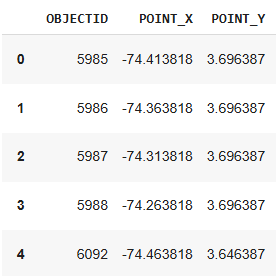

![image.png]()

Las variables disponibles con su nombre de como debe ser usado como parámetro y su unidad se detallan a continuación:

si necesita mas información se puede obtener de la documentación del servicio Web [API](https://api.climateengine.org/docs#/home/key_expiration_home_key_expiration_get) recuerde autorizar primero con su API Key

o más dataset  y variables disponibles además de ERA5 [acá](https://docs.climateengine.org/docs/build/html/variables.html?highlight=era5#era5-ag-9-6km-daily) por ejejmplo NDVI, CHIRPS u otros dataset disponibles en Climate Engine.

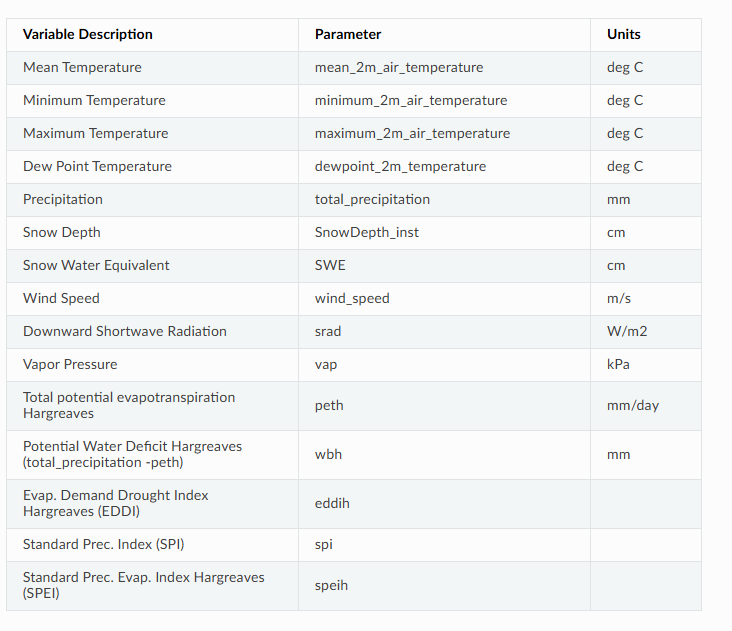

Las siguientes funciones reciben como parámetro el "Parameter" de la variable seleccionada pro el usuario, tal cual como esta escrito como un string para el caso de la función "download_data" un año en específico también como string, esto es porque se consulta año a año porque son 365 formatos ráster que se consultan de acuerdo con la cantidad de días, y se almacena uno por uno, esto evita errores de guardado por desconexión de internet.

Para este caso cree una carpeta en la pestaña "Archivos" del colab para que cada archivo *.csv sea guardado allí, ese nombre es lo que se conoce como el parámetro "path" en la función "save_data".

In [12]:

# Tu clave de API de Climate Engine, debe resgitrarse https://support.climateengine.org/article/18-create-an-account y vuelta a correo le asignarán su api Key
api_key = 'XXXX'
# Endpoint de la API de Climate Engine

def download_data(variable: str, anno: str) -> dict:
    """
    Función para descargar datos climáticos desde la API de Climate Engine.

    Parámetros:
    ----------
    variable : str
        Nombre de la variable climática a descargar (por ejemplo: 'tmmn' para temperatura mínima).
    anno : str
        Año para el cual se desea obtener los datos (en formato 'YYYY').

    Retorna:
    -------
    dict
        Respuesta en formato JSON con los datos climáticos descargados.

    Variables globales requeridas:
    -----------------------------
    - `puntos`: Lista de coordenadas geográficas en formato GeoJSON (debe estar definido previamente).
    - `api_key`: Clave de acceso a la API de Climate Engine (debe estar definido previamente).

    Ejemplo de uso:
    --------------
    >>> download_data('tmmn', '2023')

    Notas:
    ------
    - La función requiere conexión a internet.
    - La API devuelve un código de error si las credenciales o los parámetros son incorrectos.
    """

    # URL de la API de Climate Engine
    url = 'https://api.climateengine.org/timeseries/native/coordinates'

    # Definir el cuerpo de la solicitud (payload)
    payload = {
        "dataset": "ERA5_AG",   # Dataset ERA5-Land acá se puede cambiar el parámetro según el dataset seleccionado
        "variable": variable,  # Variable climática ver el catalogo de variables de ERA5_AG
        "coordinates": puntos,  # Coordenadas geográficas (deben estar definidas globalmente)
        "start_date": f"{anno}-01-01",
        "end_date": f"{anno}-12-31",
        "area_reducer": "mean"  # Método de reducción espacial (promedio)
    }

    # Encabezados con la clave de autorización
    headers = {
        'Authorization': api_key  # Clave API (debe estar definida globalmente)
    }

    # Realizar la solicitud GET a la API
    try:
        response = requests.get(url, params=payload, headers=headers, verify=False)

        # Verificar si la solicitud fue exitosa
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error {response.status_code}: {response.text}")
            return None

    except requests.RequestException as e:
        print(f"Error de conexión: {e}")
        return None



def save_data(anno: str, variable: str, path: str):
    """
    Guarda los datos climáticos descargados en un archivo CSV.

    Parámetros:
    ----------
    anno : str
        Año de los datos a descargar (formato 'YYYY').
    variable : str
        Variable climática a obtener (por ejemplo: 'tmmn' para temperatura mínima).
    path : str
        Ruta donde se guardará el archivo CSV.

    Retorna:
    -------
    None
        Si no se pueden obtener datos, la función termina sin guardar nada.

    Variables globales requeridas:
    ------------------------------
    - `coordenadas`: Un DataFrame con las coordenadas y sus identificadores.
    - `download_data(variable, anno)`: Función que obtiene los datos climáticos.

    Descripción del proceso:
    ------------------------
    1. Descarga los datos climáticos usando `download_data(variable, anno)`.
    2. Si la respuesta es `None`, finaliza sin guardar nada.
    3. Extrae los identificadores de las coordenadas desde los metadatos de los datos obtenidos.
    4. Mapea los identificadores con los nombres de las coordenadas.
    5. Extrae la variable climática de interés y organiza los datos en listas.
    6. Crea un DataFrame de pandas con las coordenadas como columnas y las fechas como índice.
    7. Guarda el DataFrame como un archivo CSV en la ruta especificada.

    Ejemplo de uso:
    --------------
    >>> save_data('2023', 'tmmn', './datos/')

    Notas:
    ------
    - La función requiere acceso a los datos descargados mediante `download_data`.
    - La variable `coordenadas` debe estar definida y contener las coordenadas formateadas y los IDs.
    - Asegúrate de que la ruta `path` exista antes de ejecutar la función.

    """

    # Descargar los datos
    data = download_data(variable, anno)

    # Si no se obtienen datos, salir de la función
    if data is None:
        return None

    # Lista para almacenar los datos de cada punto
    datos = []

    # Extraer identificadores de coordenadas
    columns = [x['Metadata']['DRI_OBJECTID'] for x in data]

    # Crear un diccionario para mapear los IDs con los nombres de las coordenadas
    dict_names = dict(zip(coordenadas['Coordenadas_Formateadas'], coordenadas['OBJECTID'].astype(str)))

    # Obtener nombres de las columnas a partir de los IDs
    columns_names = [dict_names[x] for x in columns]

    # Extraer el nombre de la variable climática desde los datos
    nombre_var = list(data[0]['Data'][0].keys())[1]

    # Procesar los datos y organizarlos en listas
    for punto in data:
        name = punto['Metadata']['DRI_OBJECTID']
        temperaturas = [dato[nombre_var] for dato in punto['Data']]
        datos.append(temperaturas)

    # Crear un DataFrame con las coordenadas como columnas
    salida = pd.DataFrame(list(zip(*datos)), columns=columns_names)

    # Agregar la columna de fechas
    salida['date'] = [x['Date'] for x in data[0]['Data']]

    # Construir el nombre del archivo
    nombre_archivo = f"{variable}_{anno}.csv"

    # Guardar el DataFrame como CSV en la ruta especificada
    salida.to_csv(path + nombre_archivo, index=False)



a continuación se presenta un ejemplo donde se descargarán 10 años de datos de temperatura media diaria para las coordenadas indicadas, en la carpeta precreada "temp_media", este proceso puede tardar hasta 1 hora depende de la velocidad de su internet, si no necesita cambiar el dataset de ERA5 **no modifique las funciones** sólo tendrá que incluir su variable, el rango de años y el nombre de la carpeta donde se almacenaran temporalmente los archivos, a continuación:

In [18]:
for anno in range(2024,2025):
  save_data(str(anno), 'mean_2m_air_temperature', '/content/temp_mean/')

Seguidamente se unirán los archivos de año por año en uno solo archivo que se almecenará en la pestaña de "Archivos" del colab.

In [19]:
# Definir el directorio donde están almacenados los archivos CSV, el mismo que usó como path en el paso anterior
directorio = '/content/temp_mean'

# Obtener la lista de todos los archivos CSV en el directorio
archivos_csv = [f for f in os.listdir(directorio) if f.endswith('.csv')]

# Leer y concatenar todos los archivos CSV en un solo DataFrame
dataframes = []
for archivo in archivos_csv:
    ruta_completa = os.path.join(directorio, archivo)
    df = pd.read_csv(ruta_completa)
    dataframes.append(df)

# Concatenar todos los DataFrames en uno solo
df_concatenado = pd.concat(dataframes, ignore_index=True)

# Guardar el DataFrame concatenado en un nuevo archivo CSV
df_concatenado.to_csv('temp_mean.csv', index=False)

# print("Archivos concatenados y guardados con éxito en 'archivo_concatenado.csv'.")


Finalmente, como el archivo de salida para este ejemplo es bastante pesado mas de 20 Mb en ocasiones presenta errores de descarga por lo que se almacenará directamente en la carpeta de Drive del usuario google con el que se está ejecutando este notebook, es necesario que se autentique para que pueda ser almacenado en el drive sin prioblemas, y luego descargarse.

In [ ]:
df =  pd.read_csv('/content/temp_mean.csv')
# Montar Google Drive
drive.mount('/content/drive')
# Especificar la ruta en Google Drive donde deseas guardar el archivo
ruta_guardar = '/content/drive/My Drive/temp_mean.csv'

# Guardar el DataFrame como un archivo CSV en la ruta especificada
df.to_csv(ruta_guardar, index=False)

print(f"Archivo guardado en {ruta_guardar}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archivo guardado en /content/drive/My Drive/temp_mean.csv


# Bibliografía
[1] Copernicus Climate Change Service, Climate Data Store, (2024): ERA5 post-processed daily-statistics on single levels from 1940 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), DOI: 10.24381/cds.4991cf48 (Accessed on 17-03-2025)